<a href="https://colab.research.google.com/github/kwonkw/Air_Compressor_Abnormality/blob/main/Air_Compressor_Abnormality_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 기본 설정

In [129]:
import random
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(37) # Seed 고정


In [70]:
from google.colab import drive
drive.mount('/content/gdrive')
train= pd.read_csv('/content/gdrive/MyDrive/ai factory/dataset/train_data.csv')
test= pd.read_csv('/content/gdrive/MyDrive/ai factory/dataset/test_data.csv')
sam= pd.read_csv('/content/gdrive/MyDrive/ai factory/dataset/answer_sample.csv')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# train EDA

## 데이터 시각화

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2463 entries, 0 to 2462
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   air_inflow     2463 non-null   float64
 1   air_end_temp   2463 non-null   float64
 2   out_pressure   2463 non-null   float64
 3   motor_current  2463 non-null   float64
 4   motor_rpm      2463 non-null   float64
 5   motor_temp     2463 non-null   float64
 6   motor_vibe     2463 non-null   float64
 7   type           2463 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 154.1 KB


In [7]:
train.head(3)

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type
0,1.59,41.00,0.7,20.53,1680.0,58.67,2.93,0
1,2.97,59.28,0.7,38.40,3142.0,74.91,3.75,0
2,1.91,45.29,0.7,24.73,2023.0,62.48,3.12,0


0    0.175396
1    0.149817
2    0.148599
3    0.124239
4    0.124239
5    0.101096
6    0.101096
7    0.075518
Name: type, dtype: float64


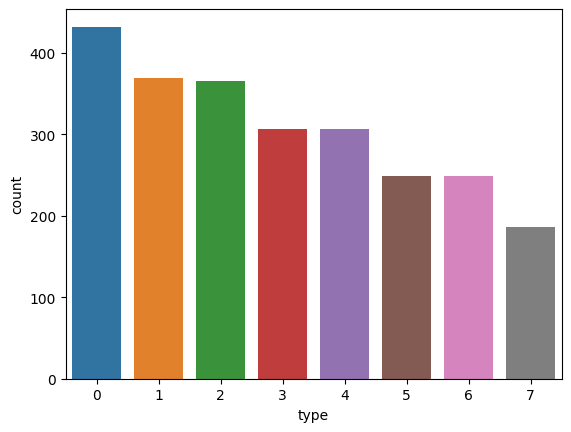

In [8]:
# type
print(train['type'].value_counts()/train.shape[0])
sns.countplot(x = train['type'])
plt.show()


**train**


1.   air_end_temp, moter_temp 같은 분포를 가짐
2.   air_inflow, motor_current 같은 분포를 가짐
3.   motor_vibe 이상치 가짐 > 이상치를 제거해 봄
4.   type은 이산형 변수 type별로 쪼개서 EDA

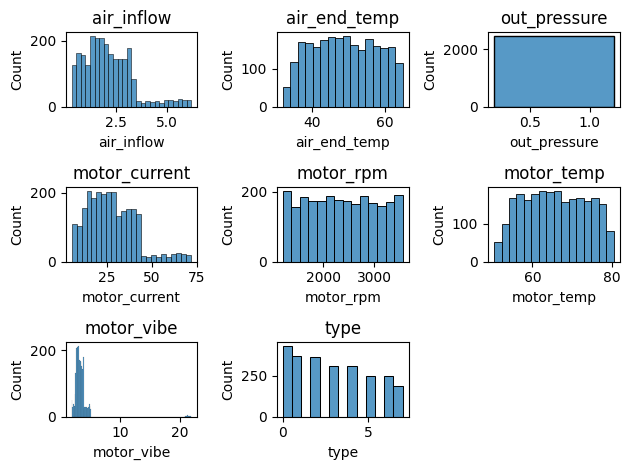

In [9]:
col = train.columns

for column in col:
    plt.subplot(3, 3, col.get_loc(column) + 1)
    sns.histplot(train[column])
    plt.title(column)

plt.tight_layout()
plt.show()

**train(이상치 제거)**


1.   motor_vibe 이상치 제거(기초통계량, boxplot 확인 후 20을 기준으로 20보다 큰 값 이상치로 판단)
2.   제거해 본 결과 제거 전과 다른 분포를 보이는 변수 없음
3.   motor_vibe와 같은 분포를 나타내는 변수 없음

Axes(0.125,0.11;0.775x0.77)
count    2463.000000
mean        3.452972
std         1.576386
min         1.970000
25%         2.880000
50%         3.260000
75%         3.730000
max        21.870000
Name: motor_vibe, dtype: float64


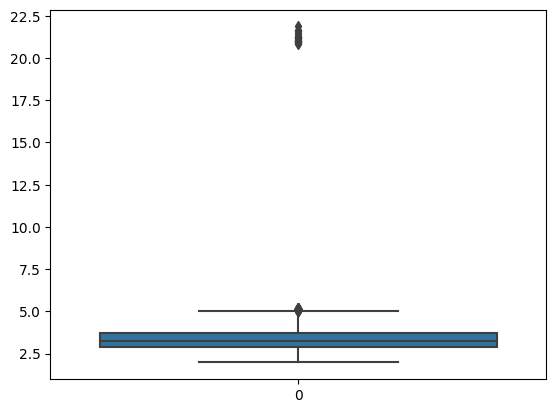

In [10]:
print(sns.boxplot(train['motor_vibe']))
print(train['motor_vibe'].describe())

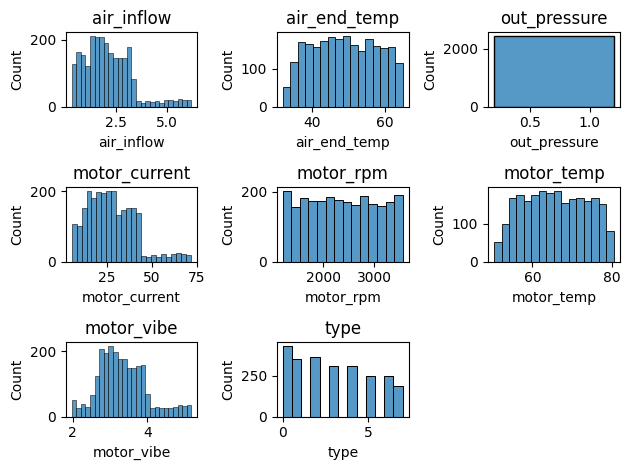

In [11]:
train_outlier = train[train['motor_vibe'] < 20]

for column in col:
    plt.subplot(3, 3, col.get_loc(column) + 1)
    sns.histplot(train_outlier[column])
    plt.title(column)

plt.tight_layout()
plt.show()

type별로 단변량 분석

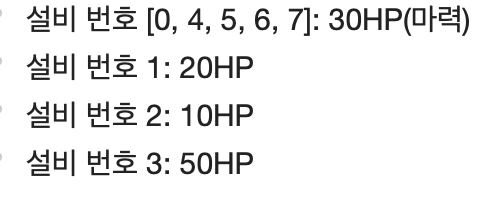

In [12]:
type0_train= train[(train['type']==0) |(train['type']==4) | (train['type']==5) | (train['type']==6) | (train['type']==7) ]
type1_train= train[(train['type']==1)]
type2_train= train[(train['type']==2)]
type3_train= train[(train['type']==3)]

**type0_train(설비번호 0,4,5,6,7/ 마력 30HP)**


1.   모든 변수 비슷한 분포를 가짐



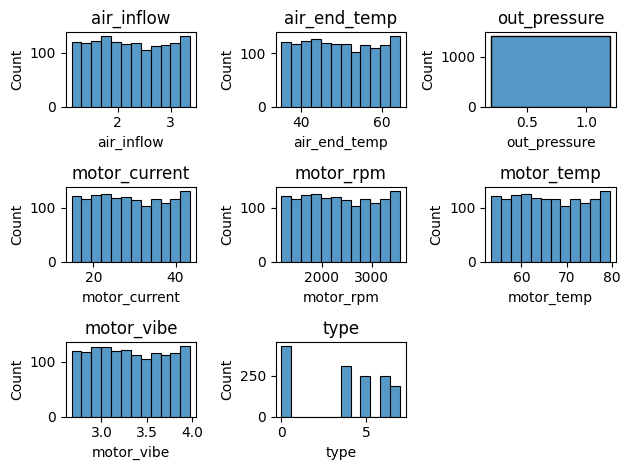

In [13]:
for column in col:
    plt.subplot(3, 3, col.get_loc(column) + 1)
    sns.histplot(type0_train[column])
    plt.title(column)

plt.tight_layout()
plt.show()


**type1_train(설비번호 1/ 마력 20HP)**


1.   air_end_temp, motor_rpm, moter_temp 비슷한 분포를 가짐
4.   motor_vibe 이상치 가짐 > 이상치를 제거해 봄


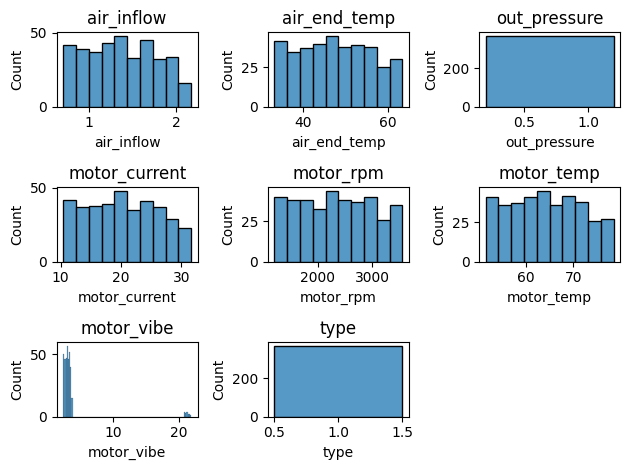

In [14]:
for column in col:
    plt.subplot(3, 3, col.get_loc(column) + 1)
    sns.histplot(type1_train[column])
    plt.title(column)

plt.tight_layout()
plt.show()

**type1_train(이상치제거)**


1.   motor_vibe 이상치 제거(기초통계량, boxplot 확인 후 20을 기준으로 20보다 큰 값 이상치로 판단)
2.   이상치만 따로 확인해 본 결과, 모두 비슷한 분포를 보임
3.   air_inflow, motor_current 비슷한 분포를 보임

In [15]:
type1_train['motor_vibe'].describe()

count    369.000000
mean       3.901572
std        3.711264
min        2.470000
25%        2.810000
50%        3.140000
75%        3.460000
max       21.870000
Name: motor_vibe, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x79b3fde0a7d0>,
 'caps': [<matplotlib.lines.Line2D at 0x79b3fde0abf0>,
 'boxes': [<matplotlib.lines.Line2D at 0x79b3fde0a530>],
 'medians': [<matplotlib.lines.Line2D at 0x79b3fde0b130>],
 'fliers': [<matplotlib.lines.Line2D at 0x79b3fde0b3d0>],
 'means': []}

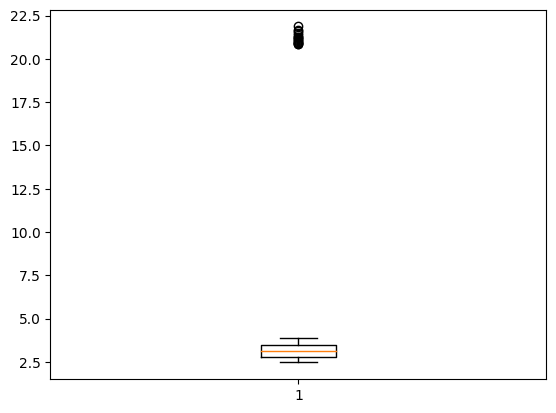

In [16]:
plt.boxplot(type1_train['motor_vibe'])

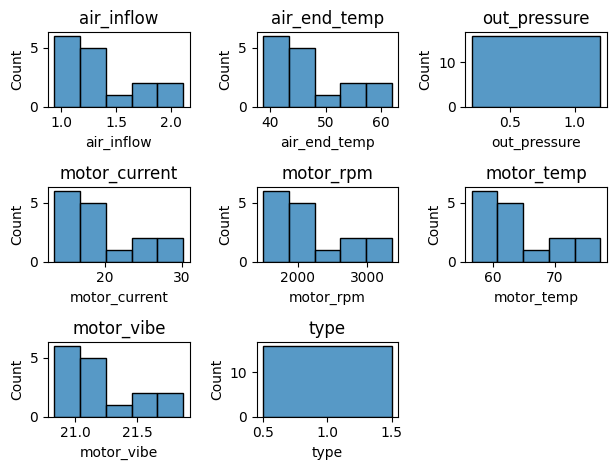

In [17]:
type1_outlier = type1_train[type1_train['motor_vibe'] > 20]

for column in col:
    plt.subplot(3, 3, col.get_loc(column) + 1)
    sns.histplot(type1_outlier[column])
    plt.title(column)

plt.tight_layout()
plt.show()

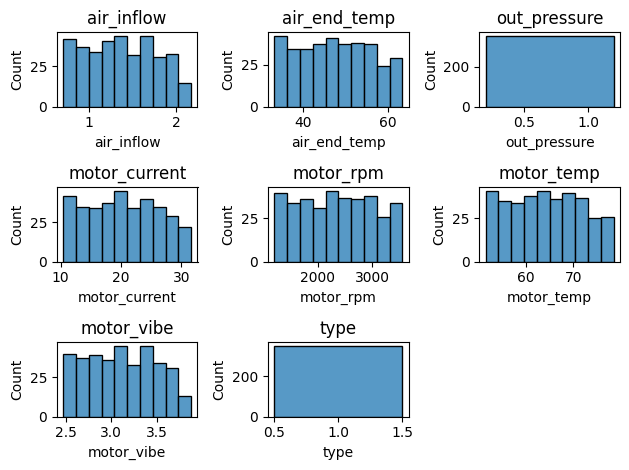

In [18]:
type1_inlier = type1_train[type1_train['motor_vibe'] < 20]

for column in col:
    plt.subplot(3, 3, col.get_loc(column) + 1)
    sns.histplot(type1_inlier[column])
    plt.title(column)

plt.tight_layout()
plt.show()

**type2_train(설비 번호 2, 마력 10HP)**


1.   motor_vibe 이상치 제거(기초통계량, boxplot 확인 후 20을 기준으로 20보다 큰 값 이상치로 판단)
2.   이상치만 따로 확인해 본 결과, 모두 비슷한 분포를 보임
3.   air_inflow, motor_current 비슷한 분포를 보임

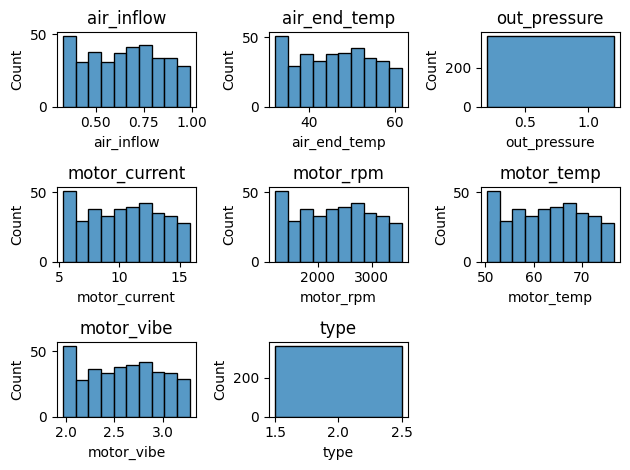

In [19]:
for column in col:
    plt.subplot(3, 3, col.get_loc(column) + 1)
    sns.histplot(type2_train[column])
    plt.title(column)

plt.tight_layout()
plt.show()

**type3_train(설비 번호 3, 마력 50HP)**


1.   air_end_temp. motor_current, motor_rpm, motor_temp 같은 분포를 나타냄

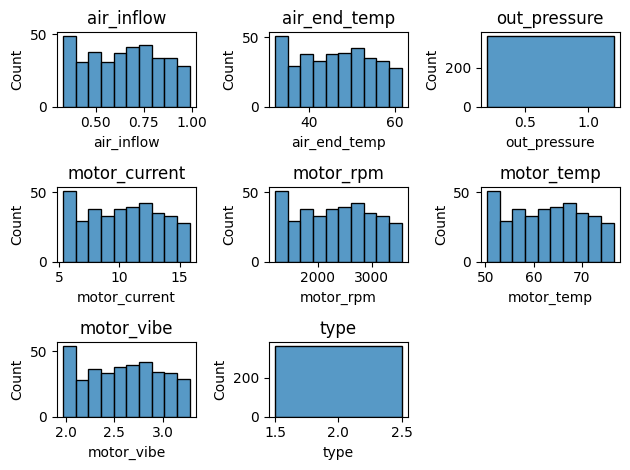

In [20]:
for column in col:
    plt.subplot(3, 3, col.get_loc(column) + 1)
    sns.histplot(type2_train[column])
    plt.title(column)

plt.tight_layout()
plt.show()

## 상관관계 확인

In [21]:
train.corr()

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type
air_inflow,1.000000,0.636467,NaN,0.994585,0.549101,0.659138,0.347755,0.169851
air_end_temp,0.636467,1.000000,NaN,0.703042,0.990302,0.999506,0.273699,0.034830
out_pressure,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
motor_current,0.994585,0.703042,NaN,1.000000,0.619536,0.723685,0.353014,0.160190
motor_rpm,0.549101,0.990302,NaN,0.619536,1.000000,0.986419,0.237544,-0.015008
motor_temp,0.659138,0.999506,NaN,0.723685,0.986419,1.000000,0.282746,0.040964
motor_vibe,0.347755,0.273699,NaN,0.353014,0.237544,0.282746,1.000000,-0.023323
type,0.169851,0.034830,NaN,0.160190,-0.015008,0.040964,-0.023323,1.000000


<Axes: >

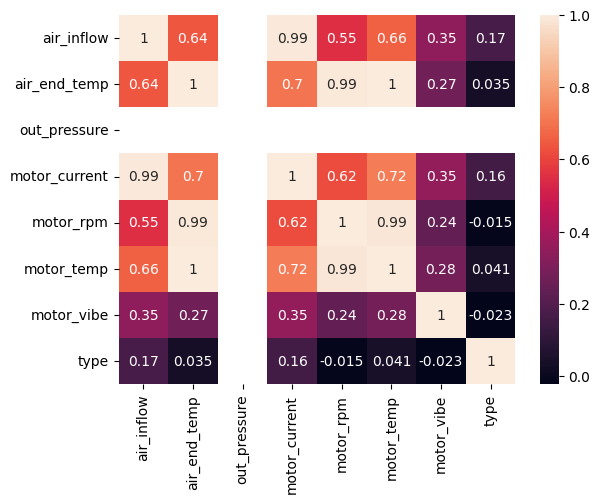

In [22]:
sns.heatmap(train.corr(), annot = True)

강한 상관관계(0.8 ~ 1.0) : air_inflow - motor_current, air_end_temp - motor_rpm , air_end_temp - motor_temp <br>
중간 상관관계(0.4 ~ 0.8) : air_inflow - motor_rpm, air_inflow - motor_temp, air_end_temp - motor_current, motor_current - motor_rpm, motor_current - motor_temp

# test EDA

## 데이터 시각화

0    0.175396
1    0.149817
2    0.148599
3    0.124239
4    0.124239
5    0.101096
6    0.101096
7    0.075518
Name: type, dtype: float64


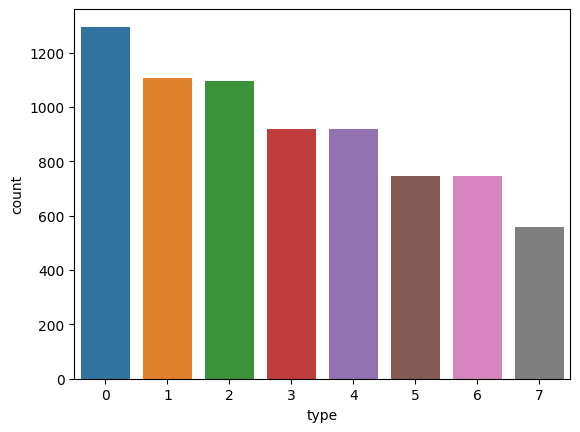

----------------------------------------------------------------------


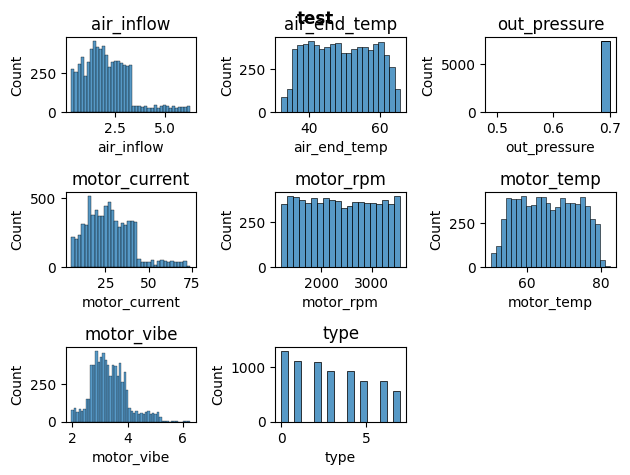

----------------------------------------------------------------------


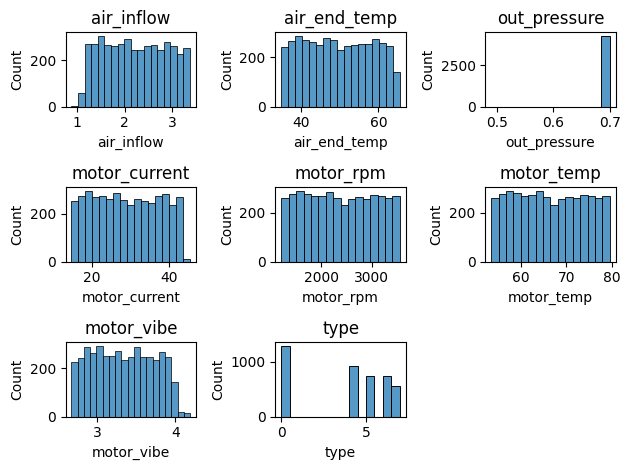

----------------------------------------------------------------------


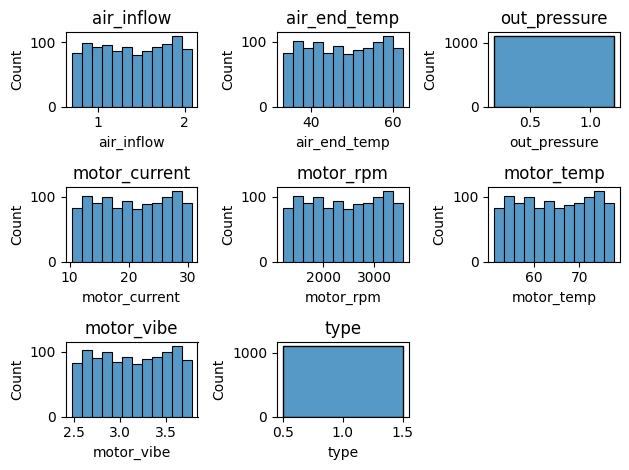

----------------------------------------------------------------------


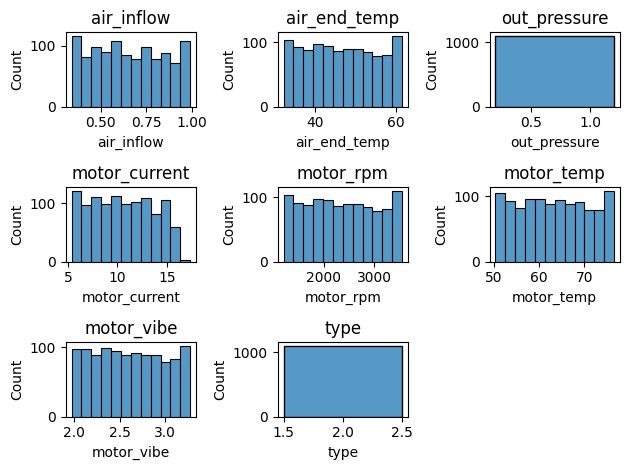

----------------------------------------------------------------------


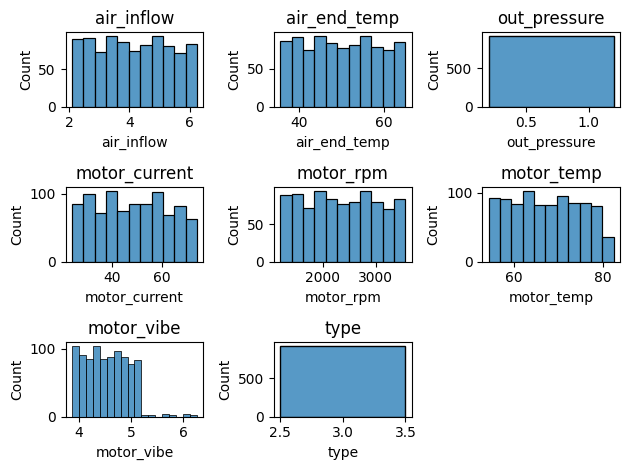

----------------------------------------------------------------------


In [23]:
print(test['type'].value_counts()/test.shape[0])
sns.countplot(x = test['type'])
plt.show()

print('-' * 70)


col = test.columns

for column in col:
    plt.subplot(3, 3, col.get_loc(column) + 1)
    sns.histplot(test[column])
    plt.title(column)

plt.tight_layout()
plt.suptitle('test', fontweight ='bold')
plt.show()

print('-' * 70)

type0_test= test[(test['type']==0) |(test['type']==4) | (test['type']==5) | (test['type']==6) | (test['type']==7) ]
type1_test= test[(test['type']==1)]
type2_test= test[(test['type']==2)]
type3_test= test[(test['type']==3)]

type_test = [type0_test, type1_test, type2_test, type3_test]

for type_list in type_test:

    for column in col:
        plt.subplot(3, 3, col.get_loc(column) + 1)
        sns.histplot(type_list[column])
        plt.title(column)
    plt.tight_layout()
    plt.show()

    print('-' * 70)

## 상관관계 확인

In [24]:
test.corr()

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type
air_inflow,1.000000,0.610628,-0.007383,0.991016,0.518147,0.635348,0.946012,0.186551
air_end_temp,0.610628,1.000000,-0.008984,0.685231,0.987989,0.995482,0.670457,0.049235
out_pressure,-0.007383,-0.008984,1.000000,-0.007960,-0.006895,-0.009131,-0.002926,-0.013889
motor_current,0.991016,0.685231,-0.007960,1.000000,0.594143,0.706455,0.954707,0.175325
motor_rpm,0.518147,0.987989,-0.006895,0.594143,1.000000,0.981809,0.588670,-0.003585
motor_temp,0.635348,0.995482,-0.009131,0.706455,0.981809,1.000000,0.691989,0.055805
motor_vibe,0.946012,0.670457,-0.002926,0.954707,0.588670,0.691989,1.000000,0.111714
type,0.186551,0.049235,-0.013889,0.175325,-0.003585,0.055805,0.111714,1.000000


<Axes: >

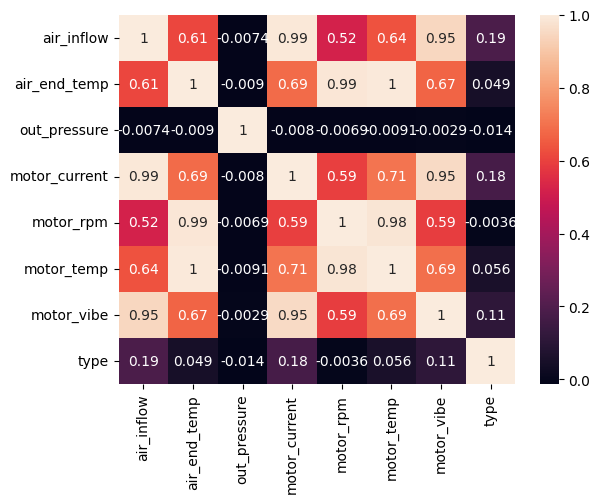

In [25]:
sns.heatmap(test.corr(), annot = True)

강한 상관관계(0.8 ~ 1.0) : air_inflow - motor_current, air_end_temp - motor_rpm , air_end_temp - motor_temp , motor_current - motor_vibe , motor_rpm - motor_temp <br>
중간 상관관계(0.4 ~ 0.8) : air_inflow - air_end_temp, air_inflow - motor_rpm, air_inflow - motor_temp, air_end_temp - motor_current,  air_end_temp - motor_vibe, motor_current - motor_rpm, motor_current - motor_temp, motor_rpm - motor_vibe, motor_temp - motor_vibe

# 파생변수 생성

1.   HP
2.   회전력(Torque) = 9.55 x 모터전류(Motor Current) x 모터RPM(Motor RPM)
3.   유효출력(Power) = 회전력(Torque) x 2 x π x 모터RPM(Motor RPM) / 60
4. 열효율(Thermal Efficiency) = (입력공기온도 - 출력공기온도) / 입력공기온도
5. 압력차이(Pressure drop): air_inflow - out_pressure로 압력 차이를 계산



In [26]:
if (test['type'] == 1).all():
    test['hp'] = 20
elif (test['type'] == 2).all():
    test['hp'] = 10
elif (test['type'] == 3).all():
    test['hp'] = 50
else:
    test['hp'] = 30
if (train['type'] == 1).all():
    train['hp'] = 20
elif (train['type'] == 2).all():
    train['hp'] = 10
elif (train['type'] == 3).all():
    train['hp'] = 50
else:
    train['hp'] = 30

In [27]:
train['Torque'] = 9.55 * train['motor_current']*train['motor_rpm']
test['Torque'] = 9.55 * test['motor_current']*test['motor_rpm']

train['Power'] = (train['Torque'] * 2 * np.pi * train['motor_rpm'])/60
test['Power'] = (test['Torque'] * 2 * np.pi * test['motor_rpm'])/60

train['Thermal_Eff'] = (train['motor_temp'] - train['air_end_temp'])/train['motor_temp']
test['Thermal_Eff'] = (test['motor_temp'] - test['air_end_temp'])/test['motor_temp']


train['Drop']=train['air_inflow']-train['out_pressure']
test['Drop']=test['air_inflow']-test['out_pressure']

In [28]:
train.head(3)

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type,hp,Torque,Power,Thermal_Eff,Drop
0,1.59,41.00,0.7,20.53,1680.0,58.67,2.93,0,30,3.293833e+05,5.794814e+07,0.301176,0.89
1,2.97,59.28,0.7,38.40,3142.0,74.91,3.75,0,30,1.152234e+06,3.791190e+08,0.208650,2.27
2,1.91,45.29,0.7,24.73,2023.0,62.48,3.12,0,30,4.777749e+05,1.012157e+08,0.275128,1.21


In [29]:
type0_train= train[(train['type']==0) |(train['type']==4) | (train['type']==5) | (train['type']==6) | (train['type']==7) ]
type1_train= train[(train['type']==1)]
type2_train= train[(train['type']==2)]
type3_train= train[(train['type']==3)]

type0_test= test[(test['type']==0) |(test['type']==4) | (test['type']==5) | (test['type']==6) | (test['type']==7) ]
type1_test= test[(test['type']==1)]
type2_test= test[(test['type']==2)]
type3_test= test[(test['type']==3)]


In [30]:
train_type = pd.get_dummies(train['type'],drop_first = True)

# 정규화

In [31]:
def minmax(train, test):
    from sklearn.preprocessing import MinMaxScaler
    mm = MinMaxScaler()
    train_scaled = mm.fit_transform(train)
    test_scaled = mm.transform(test)

    return pd.DataFrame(train_scaled), pd.DataFrame(test_scaled)


In [32]:
train_norm0, test_norm0 = minmax(type0_train, type0_test)
train_norm1, test_norm1 = minmax(type1_train, type1_test)
train_norm2, test_norm2 = minmax(type2_train, type2_test)
train_norm3, test_norm3 = minmax(type3_train, type3_test)

In [33]:
train_norm0['HP'] = 0
train_norm1['HP'] = 1
train_norm2['HP'] = 2
train_norm3['HP'] = 3

test_norm0['HP'] = 0
test_norm1['HP'] = 1
test_norm2['HP'] = 2
test_norm3['HP'] = 3

In [34]:
train_norm = pd.concat([train_norm0, train_norm1])
train_norm = pd.concat([train_norm , train_norm2])
train_norm = pd.concat([train_norm , train_norm3])

test_norm = pd.concat([test_norm0,test_norm1])
test_norm = pd.concat([test_norm , test_norm2])
test_norm = pd.concat([test_norm , test_norm3])



In [35]:
train_type = pd.get_dummies(train_norm['HP'], drop_first = True)
test_type = pd.get_dummies(test_norm['HP'], drop_first = True)
train_norm = train_norm.drop('HP', axis = 1)
test_norm = test_norm.drop('HP', axis = 1)

In [36]:
train_norm.columns = train.columns
test_norm.columns = test.columns

In [37]:
train_df = pd.concat([train_norm, train_type], axis = 1)
test_df = pd.concat([test_norm, test_type], axis = 1)

In [38]:
train_df['out_pressure'] = 0.7
test_df['out_pressure'] = 0.7

In [39]:
train = train_df.drop(['type','hp'], axis=1)
test = test_df.drop(['type','hp'], axis=1)


In [40]:
train.corr()

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,Torque,Power,Thermal_Eff,Drop,1,2,3
air_inflow,1.000000,0.999692,NaN,0.999807,0.998904,0.999732,0.822895,0.991386,0.970384,-0.993692,1.000000,-0.050105,-0.017239,0.043352
air_end_temp,0.999692,1.000000,NaN,0.999855,0.999622,0.999995,0.811682,0.991572,0.970558,-0.994324,0.999692,-0.029362,-0.024266,0.040420
out_pressure,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
motor_current,0.999807,0.999855,NaN,1.000000,0.999442,0.999851,0.815606,0.991644,0.970625,-0.994026,0.999807,-0.040075,-0.023381,0.047909
motor_rpm,0.998904,0.999622,NaN,0.999442,1.000000,0.999526,0.798320,0.991413,0.970435,-0.994250,0.998904,-0.016571,-0.026175,0.038204
motor_temp,0.999732,0.999995,NaN,0.999851,0.999526,1.000000,0.813190,0.991538,0.970521,-0.994284,0.999732,-0.030707,-0.024060,0.040568
motor_vibe,0.822895,0.811682,NaN,0.815606,0.798320,0.813190,1.000000,0.803808,0.785935,-0.799945,0.822895,-0.474463,0.056832,0.106847
Torque,0.991386,0.991572,NaN,0.991644,0.991413,0.991538,0.803808,1.000000,0.993428,-0.972439,0.991386,-0.033170,-0.024285,0.044317
Power,0.970384,0.970558,NaN,0.970625,0.970435,0.970521,0.785935,0.993428,1.000000,-0.940152,0.970384,-0.031442,-0.025186,0.043172
Thermal_Eff,-0.993692,-0.994324,NaN,-0.994026,-0.994250,-0.994284,-0.799945,-0.972439,-0.940152,1.000000,-0.993692,0.018196,0.022030,-0.035518


In [ ]:
train.isnull().sum()

air_inflow       0
air_end_temp     0
out_pressure     0
motor_current    0
motor_rpm        0
motor_temp       0
motor_vibe       0
Torque           0
Power            0
Thermal_Eff      0
Drop             0
1                0
2                0
3                0
dtype: int64

# PCA(차원축소)

In [72]:
train.columns = train.columns.astype(str)
pca = PCA()
pca.fit(train)

variance_ratio = pca.explained_variance_ratio_
print(variance_ratio)


[6.72593031e-01 1.33909759e-01 1.10595119e-01 6.82444008e-02
 9.34118119e-03 5.25890116e-03 2.83203855e-05 1.80132727e-05
 6.57308155e-06 4.50207197e-06 1.90689771e-07 7.66642674e-09
 2.11300131e-32 7.64181958e-33]


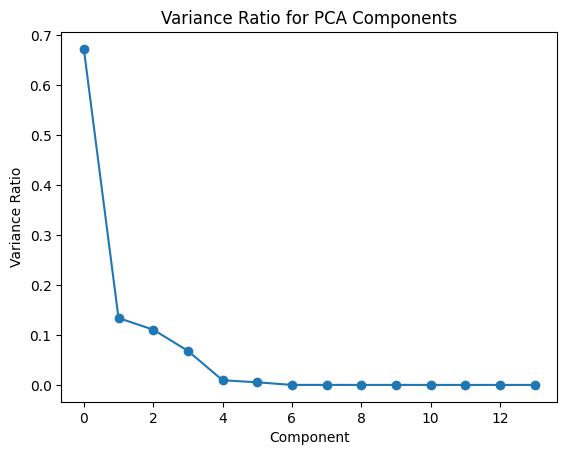

In [74]:
x = list(range(len(variance_ratio)))
y = variance_ratio

plt.plot(x, y, marker = 'o')
plt.xlabel('Component')
plt.ylabel('Variance Ratio')
plt.title('Variance Ratio for PCA Components')
plt.show()


In [75]:
test.columns = test.columns.astype(str)
pca = PCA(n_components=1)
train_pca = pca.fit_transform(train)

test_pca = pca.transform(test)

In [76]:
train_pca = pd.DataFrame(train_pca)
test_pca = pd.DataFrame(test_pca)

In [77]:
train_pca

,0
0,-0.890394
1,1.055632
2,-0.456185
3,0.177223
4,-0.464650
...,...
2458,0.497250
2459,1.098132
2460,-0.745222
2461,1.050536


# 모델학습

In [134]:
# 모델 생성
lo_clf = LocalOutlierFactor(novelty=True)
if_clf = IsolationForest(random_state=42)
svm_clf = OneClassSVM()

# 데이터 학습
lo_clf.fit(train_pca)
if_clf.fit(train_pca)
svm_clf.fit(train_pca)

# 튜닝할 하이퍼파라미터 그리드 설정
param_grid_lo = {'n_neighbors': list(range(10, 31))}
param_grid_if = {'n_estimators': list(range(50, 150, 10)), 'contamination': np.arange(0.05, 0.2, 0.01)}
param_grid_svm = {'nu': np.arange(0.05, 0.2, 0.01)}

# 각 모델에 대해 GridSearchCV 실행
grid_search_lo = GridSearchCV(lo_clf, param_grid_lo, scoring='f1_macro', cv=5)
grid_search_if = GridSearchCV(if_clf, param_grid_if, scoring='f1_macro', cv=5)
grid_search_svm = GridSearchCV(svm_clf, param_grid_svm, scoring='f1_macro', cv=5)

grid_search_lo.fit(train_pca)
grid_search_if.fit(train_pca)
grid_search_svm.fit(train_pca)

# 최적의 하이퍼파라미터 추출
best_params_lo = grid_search_lo.best_params_
best_params_if = grid_search_if.best_params_
best_params_svm = grid_search_svm.best_params_

print("Best Parameters LOF:", best_params_lo)
print("Best Parameters Isolation Forest:", best_params_if)
print("Best Parameters One-Class SVM:", best_params_svm)

# 테스트 데이터에 대한 예측 수행
lo_pred = grid_search_lo.best_estimator_.predict(test_pca)
if_pred = grid_search_if.best_estimator_.predict(test_pca)
svm_pred = grid_search_svm.best_estimator_.predict(test_pca)

# 각 모델의 예측 결과를 결합하여 최종 이상치 판단
ensemble_pred = (lo_pred + if_pred + svm_pred) / 3

pred = np.where(ensemble_pred < 0, 0, 1)


Best Parameters LOF: {'n_neighbors': 10}
Best Parameters Isolation Forest: {'contamination': 0.05, 'n_estimators': 50}
Best Parameters One-Class SVM: {'nu': 0.05}


In [132]:
sam['label'] = pred

In [133]:
sam['label'].value_counts()

1    7233
0     156
Name: label, dtype: int64

In [118]:
 sam.to_csv('/content/gdrive/MyDrive/ai factory/dataset/submission.csv',index=False)